In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch
import json
import copy
import os

from tqdm import tqdm
tqdm.pandas()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Создание буквенного датасета

In [3]:
from morse_dataset.morse_dataset import dataset_create

dataset_create(size=10)

# Создание и обработка сигнала

In [4]:
train_df = pd.read_csv('morse_dataset.csv')

<BarContainer object of 45 artists>

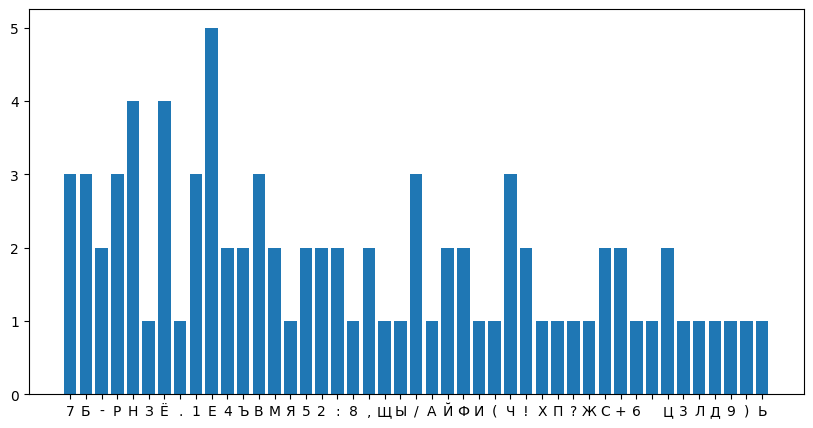

In [5]:
count_char = Counter()

for mess in train_df['message']:
    count_char.update(mess)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(count_char.keys(), count_char.values())  

In [6]:
dict_params = {
    'dt': 3000,
    'nu': 1000,
    'fs': 48000,
    'step': 50,
    'size': 960,
}

In [7]:
from morse_dataset.wav_morse import wav_save
# dt - Число отсчётов. Время точки = dt / 48000
dt = 3000
# Частота
nu = 1000
# Частота дискретизации
fs = 48000

train_df = wav_save(
    dt=dict_params['dt'],
    nu=dict_params['nu'], 
    noise=True, 
    dataset_path='morse_dataset.csv',
    fs=dict_params['fs']
)

100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


In [8]:
from stft import fft_morse


train_df['fft'] = train_df['signal'].progress_apply(
    fft_morse,
    step=dict_params['step'], 
    size=dict_params['size'],
    nu=dict_params['nu']
    )

100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


Кодировка сообщения

In [9]:
from CTC_decoder import coding_char

train_df['coding_message'] = train_df['message'].apply(coding_char)

# Нейронная сеть

Разбиение на выборки

In [10]:
X = train_df['fft']
y = train_df['coding_message']


X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Датасеты и даталодеры

In [11]:
class Band_Dataset(data.Dataset):
    def __init__(self, X, y):
        self.y = y
        self.X = X

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        band_signal = torch.tensor(self.X.iloc[idx])
        target = torch.tensor(self.y.iloc[idx])
        target_length = len(target)
        input_length = band_signal.shape[0]
        return band_signal, target, target_length, input_length

In [12]:
def collate_fn(batch):
    signals, targets, target_lengths, input_lengths = zip(*batch)
    targets_cat = torch.cat(targets)
    signals_cat = torch.nn.utils.rnn.pad_sequence(signals, batch_first=True).float()

    return {
        'signals': signals_cat.unsqueeze(1),
        'targets': targets_cat,
        'input_lengths': torch.tensor(input_lengths),
        'target_lengths': torch.tensor(target_lengths)
    }

# Проектирование нейронной сети

In [13]:
class Morse_Decoder(nn.Module):
    def __init__(self, num_char):
        super(Morse_Decoder, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=401, stride=15, padding=200),
            nn.BatchNorm1d(64),
            nn.Softplus(),
            nn.Dropout(0.3),

            nn.Conv1d(64, 64, kernel_size=21, stride=1, padding=10),
            nn.BatchNorm1d(64),
            nn.Softplus(),
            nn.Dropout(0.5),

            nn.Conv1d(64, 64, kernel_size=11, stride=1, padding=5),
            nn.BatchNorm1d(64),
            nn.Softplus(),
            nn.Dropout(0.3),
        )

        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=64,
            num_layers=2, 
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.output_layer = nn.Sequential(
            nn.Linear(128, num_char),
        )

    def forward(self, inp):
        # batch, channel, time
        x = self.hidden_layer(inp)
        # batch, time, channel
        x = x.permute(0, 2, 1)

        x, _ = self.lstm(x)
        x = self.output_layer(x)

        # time, batch, channel
        x = x.permute(1, 0, 2)
        return x

# Настройка

In [14]:
with open('morse_dict.json', 'r') as file:
    morse_code = json.load(file)
model = Morse_Decoder(len(morse_code)+1)

In [15]:
loss_func = nn.CTCLoss(blank=0)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
epochs = 100
batch_size = 32

In [16]:
train_dataset = Band_Dataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               collate_fn=collate_fn,
                               )

train_val_dataset = Band_Dataset(X_val, y_val)
train_loader_val = data.DataLoader(train_val_dataset,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   collate_fn=collate_fn
                                   )

# Обучение

In [18]:
Q_val = 9999
best_loss = 9999
model.to(device)

for _e in range(epochs):
    model.train()
    loss_mean = 0
    lm_count = 0
    train_tqdm = tqdm(train_loader, leave=True)
    for batch_dict in train_tqdm:
        batch_dict = {k: n.to(device) for k, n in batch_dict.items()}
        predict = model(batch_dict['signals'])
        predict = nn.functional.log_softmax(predict, dim=2)
        input_lengths = torch.full((predict.shape[1], ), predict.shape[0])
        loss = loss_func(predict, batch_dict['targets'], input_lengths, batch_dict['target_lengths'])

        assert not torch.isnan(loss).any()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}, last loss_val: {Q_val:.3f}, lr={scheduler.get_last_lr()}")

    model.eval()
    # Валидационная выборка
    lm_count_val = 0
    loss_mean_val = 0
    for batch_dict_val in train_loader_val:
        with torch.no_grad():
            batch_dict_val = {k: n.to(device) for k,n in batch_dict_val.items()}
            predict = model(batch_dict_val['signals'])
            predict = nn.functional.log_softmax(predict, dim=2)
            input_lengths = torch.full((predict.shape[1], ), predict.shape[0])
            loss = loss_func(predict, batch_dict_val['targets'], input_lengths, batch_dict_val['target_lengths'])

            lm_count_val += 1
            loss_mean_val = 1/lm_count_val * loss.item() + (1 - 1/lm_count_val) * loss_mean_val
    Q_val = loss_mean_val

    # early stopping
    if Q_val < best_loss:
        best_loss = Q_val
        torch.save(model.state_dict(), f'best_model.tar')
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            print("Stop! Loss val don't drop!")
            break

Epoch [1/100], loss_mean=234.111, last loss_val: 9999.000, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
Epoch [2/100], loss_mean=232.204, last loss_val: 199.632, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
Epoch [3/100], loss_mean=231.241, last loss_val: 188.219, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
Epoch [4/100], loss_mean=230.412, last loss_val: 188.505, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
Epoch [5/100], loss_mean=230.972, last loss_val: 188.464, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
Epoch [6/100], loss_mean=227.874, last loss_val: 188.098, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
Epoch [7/100], loss_mean=227.862, last loss_val: 187.904, lr=[0.001]: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


KeyboardInterrupt: 

In [27]:
pred_indices

tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3, 

In [28]:
from morse_dataset.word_to_morse import morse_generator
from CTC_decoder import CTC_decoder
from stft import fft_morse
from model_class import Morse_Decoder

msg = 'привет'
# dt - Число отсчётов. Время точки = dt / 48000
dt = 3000
# Частота
nu = 1000
# Частота дискретизации
fs = 48000
step = 50
size = 960

signal = morse_generator(msg, dt, nu, noise=True, dev=0.5)
signal = np.float32(signal / np.max(np.abs(signal)))
fft_transform = fft_morse(signal, step=step, size=size, nu=nu, fs=fs)
signal_stft = torch.tensor(fft_transform, dtype=torch.float)

model = Morse_Decoder(57)
weights = torch.load('best_model.tar', weights_only=True)
model.load_state_dict(weights)
model.eval()

with torch.no_grad():
    predict = model(signal_stft.unsqueeze(0).unsqueeze(0))
    predict = nn.functional.log_softmax(predict, dim=-1)
    pred_indices = torch.argmax(predict, dim=-1)
    pred_indices = pred_indices.permute(1, 0).squeeze(0)
    main_answer = CTC_decoder(pred_indices)
    
print(main_answer)

['В']


In [5]:
from  neural import morse_processing

msg = 'Привет'
print(*morse_processing(msg, dev=0.5))

В
